# Ground Navigation for Aerial Vehicles

With a satellite reference image, we intend to utilize a SfM solution to match ground segments of images to the reference map.
- Inputs: Reference image (satellite), SfM solution (images, points, cameras), selected images (5)
- Output: Correction solutions for translation, rotation, scaling

#### Note: CREATING FIGURE 1

In [1]:
import numpy as np
import cv2
import open3d as o3d
import plotly.graph_objects as go
import plotly.io as pio
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree
import imageio
import copy
# %matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.path import Path

from groundNAV_agent import *
from colmapParsingUtils import *
# import pycolmap

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


#### NOTES: 
- OS in JUMBOS: IMG_9446; ID = 4
- 40yd (far hash): IMG_9520; ID = 78
- Jumbo logo: IMG_9531; ID = 89
- 30yd (near hash): IMG_9542; ID = 100
- U in JUMBOS: IMG_9576; ID = 134

#### New imgs - things near OS
- S: top half: IMG_9449
- O in Jumbos: IMG_9459
- Section of B in Jumbos: IMG_9467
- Edge to endzone nearside: IMG_9473
- 10 yd nearside: IMG_9476
- M: top half: IMG_9580 (Subbing for image 1) - Not great 
- 10 yd near hash IMG_9475 (Subbing for image 1)
- S bottom corner: IMG_9464 (Subbing for image 2)

In [2]:
# # Load in necessary parameters for gNAV agent 
# # Define Class Parameters 

# images_colm  = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/images.txt"
# cameras_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/cameras.txt"
# pts3d_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/points3D_f.txt"

# # Images selected for local corrections
image_6 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9446.JPEG" #ID:4
image_7 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9520.JPEG" #ID:78
image_8 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9531.JPEG" #ID:89
image_9 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9542.JPEG" #ID:100
image_10 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9576.JPEG" #ID:134
# # Load in satellite reference image
# sat_ref = "TTurf/TurfSat.jpg"
# # sat_ref = cv2.imread('TTurf/TurfSat.jpg')

# # Organize for agent params
# images = [image_1, image_2, image_3, image_4, image_5]

In [3]:
# CLOSER IMAGES 
# Load in necessary parameters for gNAV agent 
# Define Class Parameters 

images_colm  = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/images.txt"
cameras_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/cameras.txt"
pts3d_colm = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/test/points3D_f.txt"

# Images selected for local corrections
# image_1 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9449.JPEG"
image_1 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9475.JPEG"
# image_2 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9459.JPEG"
image_2 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9464.JPEG"
image_3 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9467.JPEG"
image_4 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9473.JPEG"
image_5 = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9476.JPEG"
# Load in satellite reference image
sat_ref = "TurfSat.jpg"
# sat_ref = cv2.imread('TTurf/TurfSat.jpg')

# Organize for agent params
images = [image_1, image_2, image_3, image_4, image_5, image_6, image_7, image_8, image_9, image_10]

In [4]:
# Create class
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, images, sat_ref)

# Grab raw points and RGB data for scene and reference cloud
scene_pts, rgb_data = gnav.grab_pts(gnav.pts3d_c)
ref_pts, ref_rgb = gnav.ref_pts, gnav.ref_rgb

In [5]:
def get_pose_id_mod(id):
    """
    Get the pose transformation for a specific image id
    Input: Image ID
    Output: transform from camera to world coordinates
    """
    # Get quaternion and translation vector
    qvec = gnav.images_c[id].qvec
    tvec = gnav.images_c[id].tvec[:,None]
    # print(tvec)
    t = tvec.reshape([3,1])
    # Create rotation matrix
    Rotmat = qvec2rotmat(qvec) # Positive or negative does not matter
    # print("\n Rotation matrix \n", Rotmat)
    # Create 4x4 transformation matrix with rotation and translation
    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
    w2c = np.concatenate([np.concatenate([Rotmat, t], 1), bottom], 0)
    c2w = np.linalg.inv(w2c)
    # self.im_pts_2d[imnum]['w2c'] = w2c
	# self.im_pts_2d[imnum]['c2w'] = c2w
    return w2c, c2w

In [6]:

# Grab all poses 
# print(gnav.images_c)
poses = np.zeros([len(gnav.images_c),4,4])
skip_indices = {0, 11, 18, 66, 84, 85}

for n in range(len(gnav.images_c)):
    # print(n)
    if n in skip_indices:
        continue
    __, c2w = get_pose_id_mod(n)
    # print(c2w)
    poses[n] = c2w

print(poses)

[[[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.98903487  0.0360651   0.14321083  0.89654748]
  [-0.04958415  0.99452539  0.09198188  1.17396941]
  [-0.13910947 -0.09807427  0.98540854 -5.73572927]
  [ 0.          0.          0.          1.        ]]

 [[ 0.99645954 -0.03948148  0.07422666  0.88124041]
  [ 0.07167729  0.86037321 -0.50459915  1.04724918]
  [-0.04394031  0.508133    0.86015702 -5.68199568]
  [ 0.          0.          0.          1.        ]]

 ...

 [[ 0.99247778 -0.02814337  0.11914613  0.22037701]
  [ 0.08061856  0.88265537 -0.46305522 -3.30642753]
  [-0.09213304  0.46917741  0.87828473 -2.26767851]
  [ 0.          0.          0.          1.        ]]

 [[ 0.99174689  0.0940716   0.08711286  0.19340006]
  [-0.12800069  0.76539432  0.63070387 -3.16135289]
  [-0.00734437 -0.6366491   0.77111866 -1.94797966

In [7]:
# PLOT INITIAL POINT CLOUD AND POSES 
# Create Open3D visualizer object
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='3D Plot with Pose Axes and Point Cloud')#, width=1000, height=1000)

# Add coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)

# loop through poses 
for pose in poses:
    if (pose == 0).all():
        continue
# for i in range(1):
    # print(i)
    # homog_t = poses[i]
    homog_t = pose
    print(homog_t)
    # axes1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1).transform(homog_t)
    axes1 = copy.deepcopy(axes).transform(homog_t)
    vis.add_geometry(axes1)
    
scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

vis.add_geometry(axes)
vis.add_geometry(scene_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run the visualizer
vis.run()
vis.destroy_window()


libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 74
pci id for fd 74: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


[[ 0.98903487  0.0360651   0.14321083  0.89654748]
 [-0.04958415  0.99452539  0.09198188  1.17396941]
 [-0.13910947 -0.09807427  0.98540854 -5.73572927]
 [ 0.          0.          0.          1.        ]]
[[ 0.99645954 -0.03948148  0.07422666  0.88124041]
 [ 0.07167729  0.86037321 -0.50459915  1.04724918]
 [-0.04394031  0.508133    0.86015702 -5.68199568]
 [ 0.          0.          0.          1.        ]]
[[ 0.99429098  0.02635818  0.10339584  0.84421947]
 [-0.03463061  0.99626924  0.07904634  0.91755269]
 [-0.10092658 -0.08217572  0.99149432 -5.43382844]
 [ 0.          0.          0.          1.        ]]
[[ 9.98279206e-01 -5.03723739e-02  3.00208235e-02  8.07279503e-01]
 [ 5.86330766e-02  8.65188026e-01 -4.98007873e-01  7.97854170e-01]
 [-8.87818184e-04  4.98911118e-01  8.66652703e-01 -5.22152171e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99982567  0.01688037  0.00798076  0.80145146]
 [-0.0171978   0.99898889  0.04153827  0.80928078]
 [-0.00727151 

### Changing REF FRAME TO MIDDLE

In [8]:
# Use ground plane pts to set reference frame 
# Need gravity and height
pts_gnd_idx = np.array([25440, 25450, 25441, 25449, 25442, 25445, 103922, 103921, 103919, 103920])
# tform_ref_frame = gnav.set_ref_frame(pts_gnd_idx) # THIS IS WHAT I AM CHANGING 
tform_ref_frame = gnav.set_ref_frame_mid(pts_gnd_idx) # NEW VERSION
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Note:** Old reference frame  

$$
\left(\begin{array}{cccc}
0.093007 & -0.62871317 & -0.77205534 & 2.75319285 \\
0.10842898 & 0.77720038 & -0.61984088 & 3.0928447 \\
0.98974383 & -0.02606363 & 0.1404558 & 0.72813416 \\
0.0 & 0.0 & 0.0 & 1.0
\end{array}\right)
$$


New reference frame 
$$
\left(\begin{array}{cccc}
0.0930070004 & -0.628713172 & -0.772055338 & 143.636398 \\
0.108428981 & 0.777200383 & -0.619840884 & 15.4185280 \\
0.989743833 & -0.0260636319 & 0.140455805 & 0.728134156 \\
0.0 & 0.0 & 0.0 & 1.0
\end{array}\right)
$$


In [9]:
# Transform all points to the new coordinate system 
# Not necessary since we aren't using the cloud, but a good visual check for coord frame
tform_ref_frame_inv = gnav.inv_homog_transform(tform_ref_frame)
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(scene_pts, gnav.origin_w, tform_ref_frame_inv)
# print(origin_ref)
# Transform scene cloud to 2D (also as a visual check)
# Note: 2d projection will look off with z=-1; see TTurf_v2 for cropping method
scene_ref_2d = gnav.proj_2d_scene(scene_pts_ref)
# print(scene_ref_2d)

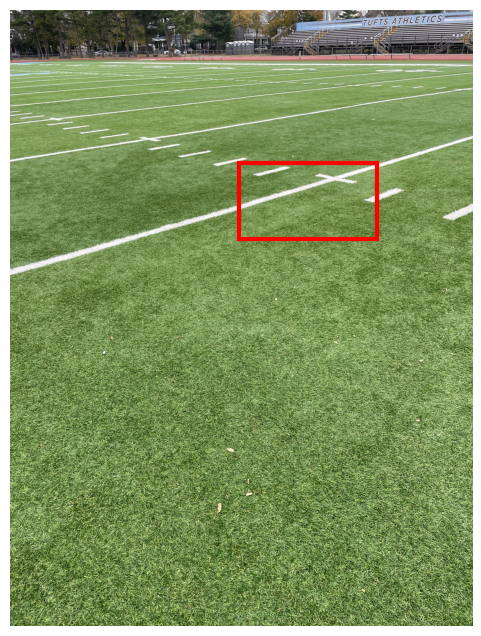

In [10]:
# Image 1 - OS in Jumbos OR top half of S

# # Top half of S
# imnum = 0
# x,y = 300,2100
# side_x = 1300 # WIDTH
# side_y = 750 # HEIGHT
# x,y = 300,2200
# side_x = 1300 # WIDTH
# side_y = 600 # HEIGHT

# # Bottom of M 
# imnum = 0
# x,y = 1100,2000
# side_x = 1300 # WIDTH
# side_y = 600 # HEIGHT

# # 10 yd hash 
imnum = 0
x,y = 1500,1000
side_x = 900 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_loc)
# print(pts_rgb)

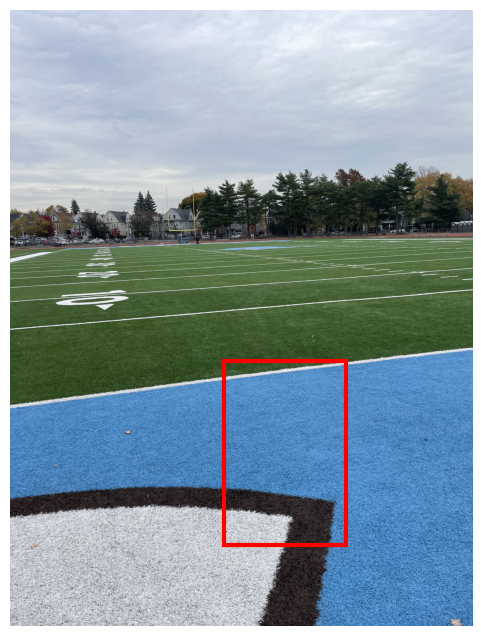

In [11]:
# Image 2 - 40yd (far), OR O in jumbos

# # O in jumbos 
# imnum = 1
# x,y = 300,1700
# side_x = 1000 # WIDTH
# side_y = 900 # HEIGHT

# Bottom of S
imnum = 1
x,y = 1400,2300
side_x = 800 # WIDTH
side_y = 1200 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

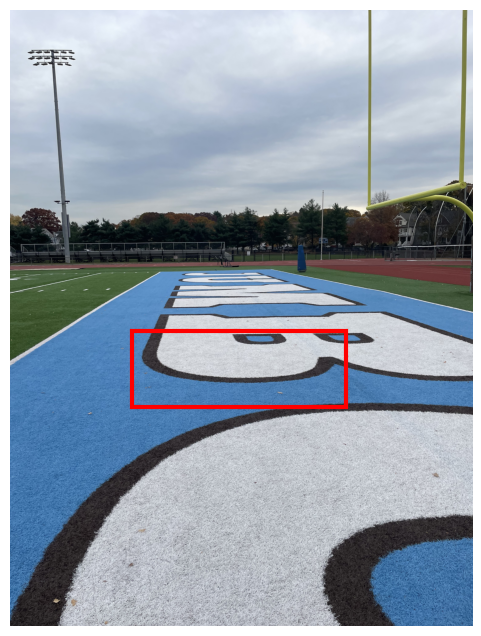

In [12]:
# Image 3 - Jumbo logo OR B in jumbos

# B in jumbos 
imnum = 2
x,y = 800,2100
side_x = 1400 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

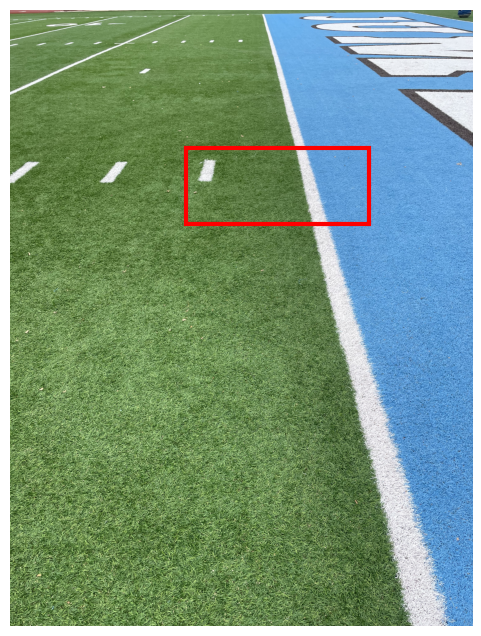

In [13]:
# Image 4 - 30yd (near) OR edge to endzone 

# Edge to endzone
imnum = 3
x,y = 1150,900
side_x = 1200 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

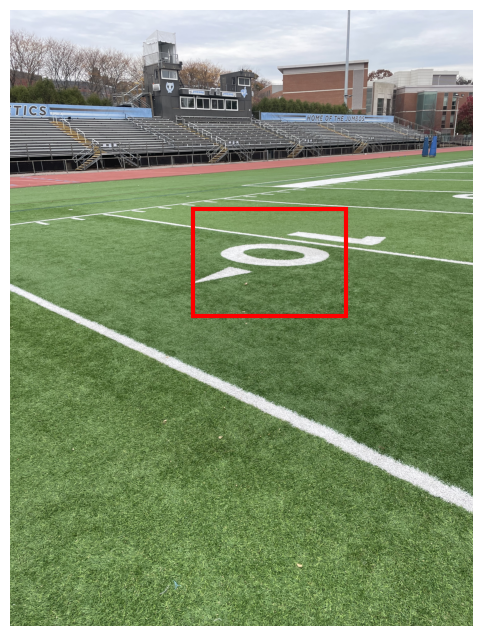

In [14]:
# Image 5 - 10yd marker
imnum = 4
x,y = 1200,1300
side_x = 1000 # WIDTH
side_y = 700 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

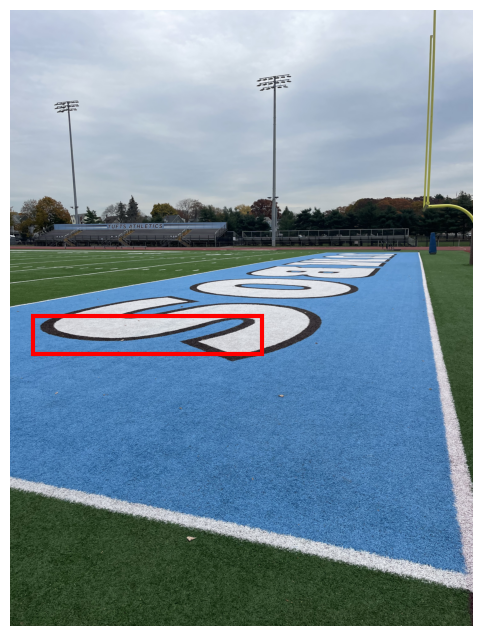

In [15]:
# Image 6 - OS in Jumbos (using bottom half of S)
imnum = 5
# x,y = 150,1725
# side_x = 2250 # WIDTH
# side_y = 750 # HEIGHT
x,y = 150, 2000
side_x = 1500
side_y = 250 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

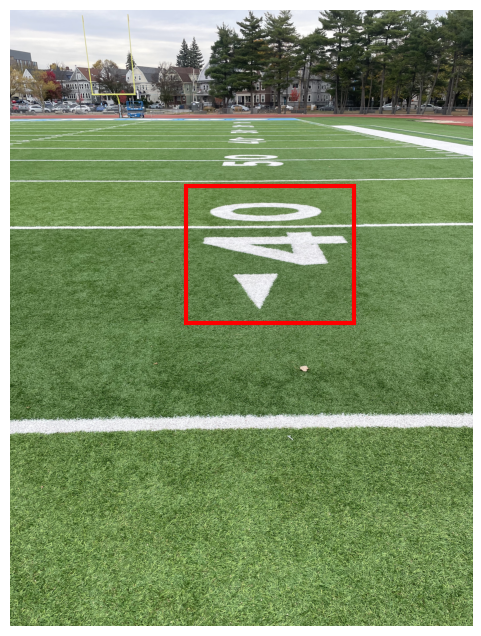

In [16]:
# Image 7 - 40yd marker
imnum = 6
x,y = 1150,1150
side_x = 1100 # WIDTH
side_y = 900 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

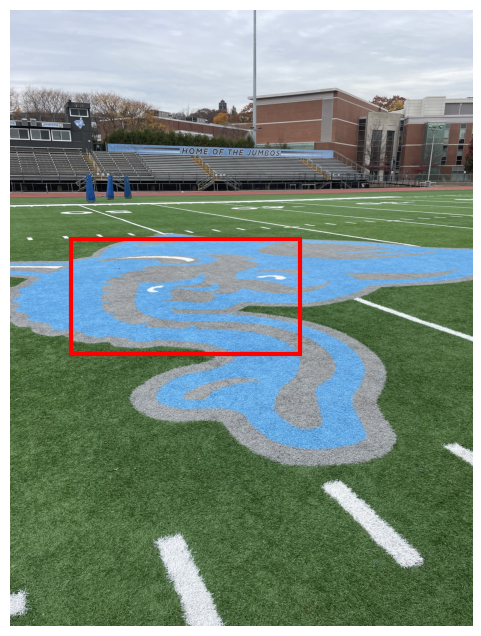

In [17]:
# Image 8 - Jumbo logo
imnum = 7
x,y = 400,1500
side_x = 1500 # WIDTH
side_y = 750 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

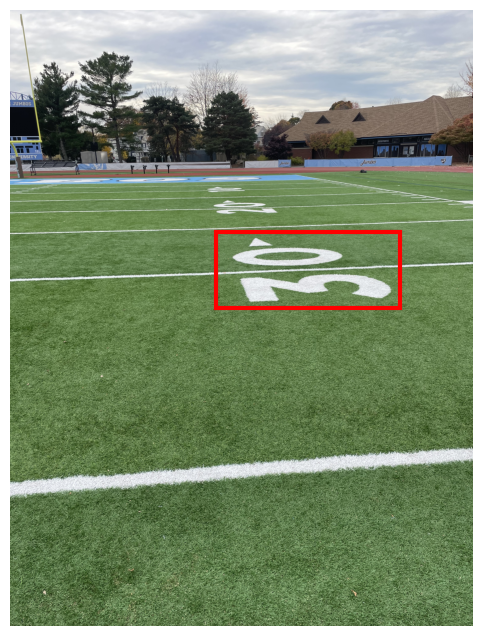

In [19]:
# Image 9 - 30yd marker (near)
imnum = 8
x,y = 1350,1450
side_x = 1200 # WIDTH
side_y = 500 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data def get_pose_id(self, id,imnum)
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

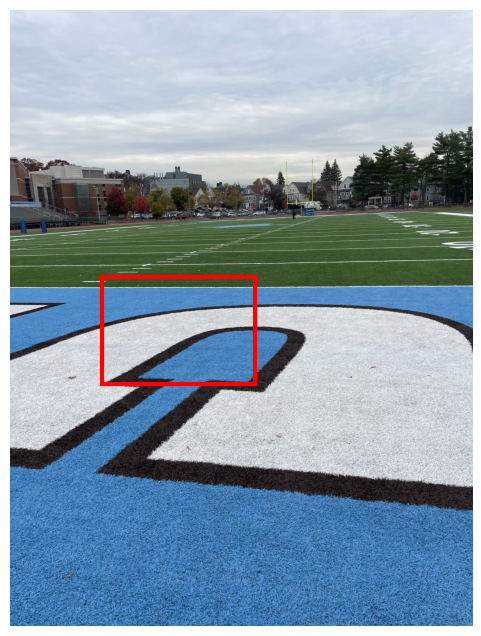

In [20]:
# Image 10 - bottom of U in Jumbos
imnum = 9
x,y = 600,1750
side_x = 1000 # WIDTH
side_y = 700 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y, imnum) 

# Get necessary location and rgb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y, imnum)
# print(pts_rgb)

In [21]:
## Generate projection of image sections 
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    # Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # Get transformation matrix that move from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5

Done image  6

Done image  7

Done image  8

Done image  9


In [22]:
# OLD GUESSES 


# scale = 87 # Avg guess OLD IMAGES
# scale = 80 # Decent average guess - Old frame, new ims

# # Avg guess for OLD IMAGES  
# x = 294
# y = 172
# yaw = np.deg2rad(1)

# # Going for average guess - new images!, old frame
# x = 331
# y = 264
# yaw = np.deg2rad(-1)
# # Corrected guess (just for 10yd line)! 
# x = 333
# y = 260
# yaw = np.deg2rad(-1)

In [23]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.25)
axis_origin.translate((-.75,0,1))

# Create point cloud for image points
im0_cloud = o3d.geometry.PointCloud()
im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['pts'])
im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for image points
im1_cloud = o3d.geometry.PointCloud()
im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['pts'])
im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# Create point cloud for image points
im2_cloud = o3d.geometry.PointCloud()
im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['pts'])
im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# Create point cloud for image points
im3_cloud = o3d.geometry.PointCloud()
im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['pts'])
im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# Create point cloud for image points
im4_cloud = o3d.geometry.PointCloud()
im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['pts'])
im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# Define the plane parameters
x_range = np.linspace(-50, 50, 1000)  # range of x values
y_range = np.linspace(-50, 50, 1000)  # range of y values
z_value = 1.0

# Create the meshgrid of x and y values
xx, yy = np.meshgrid(x_range, y_range)
zz = np.full_like(xx, z_value)

# Stack to create (N, 3) array of points
points = np.stack((xx.ravel(), yy.ravel(), zz.ravel()), axis=-1)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Optionally color the plane
pcd.paint_uniform_color([0.5, 0.5, 0.5])

# Visualize
# vis.add_geometry(pcd)


# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts_ref)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
# vis.add_geometry(ref_cloud)
vis.add_geometry(im0_cloud)
vis.add_geometry(im1_cloud)
vis.add_geometry(im2_cloud)
vis.add_geometry(im3_cloud)
vis.add_geometry(im4_cloud)
# vis.add_geometry(im5_cloud)
# vis.add_geometry(im6_cloud)
# vis.add_geometry(im7_cloud)
# vis.add_geometry(im8_cloud)
# vis.add_geometry(im9_cloud)
# vis.add_geometry(scene_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# # Set up initial viewpoint
# view_control = vis.get_view_control()
# # Direction which the camera is looking
# view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # Point which the camera revolves about 
# view_control.set_lookat([0, 0, 0])   # Set the focus point
# # Defines which way is up in the camera perspective 
# view_control.set_up([0, -1, 0])       # Set the up direction
# view_control.set_zoom(.45)           # Adjust zoom if necessary

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 83
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 83
pci id for fd 83: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [ ]:
# Implementing an initial guess for the local image 

# SCALE for initial guess 
# scale = gnav.focal/39
scale = 80

# Avg guess for OLD IMAGES  
x = -55
y = 20
yaw = np.deg2rad(140)

# BEST after CONVERGENCE
scale = 80.14819958
yaw = 2.44777939
x = -55.46495001
y = 21.62910054

# # CRAFTING A NEW GUESS FOR ALL 10 IMAGES
scale = 70
s_x = 75
s_y = 80
s_mat = np.diag([s_x, s_y, 1])
# # print(s_mat)
yaw = np.deg2rad(140)
x = -45
y = 21


tform_guess = gnav.tform_create(x,y,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale
gnav.best_guess_scale_MD = s_mat # Multi-directional (MD)
# print(tform_guess)


# NEW IMPLEMENTATION STRATEGY
for i in range(len(images)):
# Just for the first image for now
# for i in range(1):
    loc_im_pts = gnav.im_mosaic[i]['pts'].copy()
    # print(loc_im_pts)

    # loc_im_pts[:, :2] *= scale # For SINGLE scale factor
    loc_im_pts = loc_im_pts @ s_mat # For MULTI-DIRECTIONAL scale factor
    # Get new points 
    __, loc_im_pts_guess, loc_im_vec_guess = gnav.unit_vec_tform(loc_im_pts, gnav.origin_w, tform_guess)
    gnav.im_pts_best_guess[i] = {'pts': loc_im_pts_guess}
    # gnav.im_pts_best_guess[i]['tree'] = cKDTree(loc_im_pts_guess) # UNECESSARY 

    print("\nDone image ", i)

In [ ]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=40)

# Create point cloud for image points
im0_cloud = o3d.geometry.PointCloud()
im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for image points
im1_cloud = o3d.geometry.PointCloud()
im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[1]['pts'])
im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# Create point cloud for image points
im2_cloud = o3d.geometry.PointCloud()
im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[2]['pts'])
im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# Create point cloud for image points
im3_cloud = o3d.geometry.PointCloud()
im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[3]['pts'])
im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# Create point cloud for image points
im4_cloud = o3d.geometry.PointCloud()
im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[4]['pts'])
im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# Create point cloud for image points
im5_cloud = o3d.geometry.PointCloud()
im5_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[5]['pts'])
im5_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[5]['color_g'])

# Create point cloud for image points
im6_cloud = o3d.geometry.PointCloud()
im6_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[6]['pts'])
im6_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[6]['color_g'])

# Create point cloud for image points
im7_cloud = o3d.geometry.PointCloud()
im7_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[7]['pts'])
im7_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[7]['color_g'])

# Create point cloud for image points
im8_cloud = o3d.geometry.PointCloud()
im8_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[8]['pts'])
im8_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[8]['color_g'])

# Create point cloud for image points
im9_cloud = o3d.geometry.PointCloud()
im9_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[9]['pts'])
im9_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[9]['color_g'])

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
vis.add_geometry(ref_cloud)
vis.add_geometry(im0_cloud)
vis.add_geometry(im1_cloud)
vis.add_geometry(im2_cloud)
vis.add_geometry(im3_cloud)
vis.add_geometry(im4_cloud)
vis.add_geometry(im5_cloud)
vis.add_geometry(im6_cloud)
vis.add_geometry(im7_cloud)
vis.add_geometry(im8_cloud)
vis.add_geometry(im9_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# # Set up initial viewpoint
# view_control = vis.get_view_control()
# # Direction which the camera is looking
# view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # Point which the camera revolves about 
# view_control.set_lookat([0, 0, 0])   # Set the focus point
# # Defines which way is up in the camera perspective 
# view_control.set_up([0, -1, 0])       # Set the up direction
# view_control.set_zoom(.45)           # Adjust zoom if necessary

# Run and destroy visualization 
vis.run()
vis.destroy_window()

### SSD Process (using original version)

In [ ]:
# n = 5
# for imnum in range(len(images)):
# # Just for the first image for now 
# # for imnum in range(1):
# # for imnum in range(4, 5, 1):
#     ssds = gnav.ssd_nxn(n, imnum)
#     gnav.ssds_curr[imnum] = ssds
# print("Done, most recent SSDs are\n", ssds)

In [ ]:
# # NEW new LOOKUP STRATEGY - SHOULD BE FASTER - NOT WORKING (yet)
# n = 5
# for imnum in range(len(images)):
# # Just for the first image for now 
# # for imnum in range(1):
#     ssds1 = gnav.ssd_nxn_NEWnew(n, imnum)
#     gnav.ssds1_curr[imnum] = ssds1
# print("Done, SSDs are\n", ssds1)

### Plot SSD results

# Least Square Process

### Full Lsquares 

In [ ]:
# Initial guess parameters
# INITIAL GUESS Parameters
# s = 1
# theta = np.deg2rad(0)
# tp = 0
# tq = 0
s = scale
theta = yaw
tp = x
tq = y
params = np.array([s, theta, tp, tq]).reshape(4,1)
init_guess = np.array([s, theta, tp, tq]).reshape(4,1)
print("\nInitial Guess parameters\n", params)

In [ ]:
iterations = 1
n = 15
extend = 10
    
for iter_idx in range(iterations):
    # Loop through full set of images
    for imnum in range(len(images)):
        ssds = gnav.ssd_nxn(n, imnum)
        gnav.ssds_curr[imnum] = ssds
        
    # print("Most recent SSDs\n", ssds)
    

    
    
    # Create a vector from the original position to the minimum SSD location 
    cor_vecs = np.zeros((len(images), 2))
    base_vec = np.zeros((len(images), 2))
    for im_cv in range(len(images)):
    # for imnum in range(1):
        # Grab SSDs - get id of minimum
        ssds = gnav.ssds_curr[im_cv]
        # print(f"\nSSDS for image {i}\n", ssds)
        idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
        # print("\nidrow, idcol\n", idrow, idcol)
        # Define best shift vector 
        shiftx_min = idrow-n
        shifty_min = idcol-n
        # CHECK IF MIN SSD IS ON EDGE
        if shiftx_min == n or shifty_min == n:
            print(f"\n Need to extend search of image {im_cv}\n")
            print(f"\n Current shift vector = {shiftx_min, shifty_min}\n")
            ssds = gnav.ssd_nxn(n+extend, im_cv)
            gnav.ssds_curr[im_cv] = ssds
            idrow, idcol = np.unravel_index(np.argmin(ssds), ssds.shape)
            shiftx_min = idrow-(n+extend)
            shifty_min = idcol-(n+extend)
            print(f"\n New shift vector = {shiftx_min, shifty_min}\n")
            
        
        # print("\nBEST SHIFT VECTOR = ", shiftx_min, shifty_min)
        # print(f"\nBEST SSD for image {im_cv} = ", ssds[idrow, idcol])
        cor_vecs[im_cv] = shiftx_min, shifty_min
        # Get mean of satellite points for base of x and y
        sat_pts, __ = gnav.get_inside_sat_pts(im_cv, 0,0)#shiftx_min, shifty_min)
        # print("\nInside satellite points\n", sat_pts)
        basex, basey = np.mean(sat_pts[:,0]), np.mean(sat_pts[:,1])
        # print("\nBase of x and y = ", basex, basey)
        base_vec[im_cv] = basex, basey
    
    # print("\nCorrection vectors:\n", cor_vecs)
    # print("\nBase of correction vectors: \n", base_vec)
    
    points_b = np.hstack((base_vec, np.zeros((len(images), 1))))
    points_e = points_b + np.hstack((cor_vecs, np.zeros((len(images),1))))
    points = np.vstack((points_b, points_e))
    # print("\nBeginning of points: \n", points_b)
    # print("\nEnd of points: \n",points_e)
    # print("\nAll points: \n",points)
    lines = []
    for lin in range(len(images)):
        lines.append([lin,lin+len(images)])
        # print(lin, lin+len(images))
    
    # print("\nLines for OPEN3d:\n",lines)
    
    # Delta y term
    # print(cor_vecs.reshape(-1,1))
    yi = cor_vecs.reshape(-1,1)
    print("\nYi\n", yi)
    
    
    
    
    
    # Form jacobian for each image
    J = np.zeros((2*len(images),4))
    theta = params[1][0]
    s = params[0][0]
    # print(J)
    for i_m in range(len(images)):
        xpi = np.mean(gnav.im_pts_best_guess[i_m]['pts'][:,0])
        xqi = np.mean(gnav.im_pts_best_guess[i_m]['pts'][:,1])
        # print(xpi, xqi)
        # Jacobian values (2x4)
        j11 = np.cos(theta)*xpi - np.sin(theta)*xqi
        j21 = np.sin(theta)*xpi + np.cos(theta)*xqi
        j12 = -params[0][0]*(np.sin(theta)*xpi + np.cos(theta)*xqi)
        j22 = params[0][0]*(np.cos(theta)*xpi - np.sin(theta)*xqi)
        j13, j23, j14, j24 = 1, 0, 0, 1
        # print(j13)
    
        # Construct Jacobian 
        J_upper = np.hstack((j11, j12, j13, j14))  # First row block (y_p terms)
        # print("\nJ Upper\n", J_upper)
        J_lower = np.hstack((j21, j22, j23, j24))  # Second row block (y_q terms)
        # print("\nJ Lower\n", J_lower)
        j = np.vstack((J_upper, J_lower))  # Shape (2N, 4)
        # print("\nJacobian\n", j)
        J[2*(i_m):2*(i_m)+2, :] = j
    
    print("\nJACOBIAN\n", J)
    # print("\nJacobian shape: ", J.shape)
    
    # Least squares process
    JTJi = np.linalg.inv(J.T@J)
    Dalpha = JTJi@J.T@yi
    print("\nDelta Alpha:\n", Dalpha)
    
    
    
    params += Dalpha
    print("\nUpdated Params: scale, theta, tq, tp\n", params)
    
    
    
    # Apply change
    tform_mat = gnav.tform_create(params[2][0], params[3][0], 0, 0, 0, params[1][0]) # x,y,z,roll,pitch,yaw
    print("\nTransformation matrix\n", tform_mat)
    
    
    # for i_c in range(len(images)):
    # # Just for the first image for now
    # # for i in range(1):
    #     loc_im_pts = gnav.im_mosaic[i_c]['pts'].copy()
    #     # print(loc_im_pts)
    #     loc_im_pts[:, :2] *= params[0][0].astype(np.float64)
    #     # Get new points 
    #     __, loc_im_pts_NEW, __ = gnav.unit_vec_tform(loc_im_pts, gnav.origin_w, tform_mat)
    #     gnav.im_pts_best_guess[i_c]['pts'] = loc_im_pts_NEW
    #     # gnav.im_pts_best_guess[i]['tree'] = cKDTree(loc_im_pts_guess) # UNECESSARY 
    
    #     # print("\nDone image ", i)

In [ ]:
# Plotting SSD 
# Plot and visualize SSD values (was originally used in LSquares Loop 

# IMAGES TO LOOK AT: 5, 6, 8 
i = 5

# Create a 5x5 grid of x and y coordinates
# x = np.linspace(-(n+extend), (n+extend), 2*(n+extend)+1)
# y = np.linspace(-(n+extend), (n+extend), 2*(n+extend)+1)
x = np.linspace(-n, n, 2*n+1)
y = np.linspace(-n, n, 2*n+1)
Y, X = np.meshgrid(x, y)
# print(gnav.ssds_curr[i])

# print(x)
# print(X)
# print(Y)
# Best shift
idrow, idcol = np.unravel_index(np.argmin(gnav.ssds_curr[i]), gnav.ssds_curr[i].shape)
print(idrow, idcol)
shiftx_min = idrow-n
shifty_min = idcol-n
print("BEST SHIFT = ", shiftx_min, shifty_min)
print("BEST SSD = ", gnav.ssds_curr[i][idrow, idcol])

# PLOTTING A SINGLE VECTOR FIELD FOR SSD
# Create the figure and 3D axis
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D vectors
ax.quiver(X, Y, np.zeros_like(gnav.ssds_curr[i]), 
          np.zeros_like(gnav.ssds_curr[i]), np.zeros_like(gnav.ssds_curr[i]), (gnav.ssds_curr[i]/100)**1, arrow_length_ratio=0.1)


# Highlighted coordinates
highlight_coords = [(5, 14), (0, -14)]

for x_val, y_val in highlight_coords:
    # Find index in x and y arrays closest to target x_val, y_val
    x_idx = np.where(x == x_val)[0][0]
    y_idx = np.where(y == y_val)[0][0]
    
    # Get SSD value at this position
    ssd_val = (gnav.ssds_curr[i][x_idx, y_idx]/100)**1
    print(ssd_val)
    
    # Plot individual red arrow
    ax.quiver(x_val, y_val, 0, 0, 0, ssd_val, color='red', arrow_length_ratio=0.1, linewidth=5)

# Set axis limits
ax.set_xlim([-(n+extend+10), (n+extend+10)])  # X axis range
ax.set_ylim([-(n+extend+10), (n+extend+10)])  # Y axis range
ax.set_xlim([-(n+1), (n+1)])  # X axis range
ax.set_ylim([-(n+1), (n+1)])  # Y axis range
ax.set_zlim([0, (np.max(gnav.ssds_curr[i]) / 100)**1])  # Z axis range, adjust based on your data

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pixel Correction Vector Field')

In [ ]:
88.966/100

### Plot newest guess

In [ ]:
# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=40)

# Create point cloud for image points
im0_cloud = o3d.geometry.PointCloud()
im0_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[0]['pts'])
im0_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[0]['color_g'])

# Create point cloud for image points
im1_cloud = o3d.geometry.PointCloud()
im1_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[1]['pts'])
im1_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[1]['color_g'])

# Create point cloud for image points
im2_cloud = o3d.geometry.PointCloud()
im2_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[2]['pts'])
im2_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[2]['color_g'])

# Create point cloud for image points
im3_cloud = o3d.geometry.PointCloud()
im3_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[3]['pts'])
im3_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[3]['color_g'])

# Create point cloud for image points
im4_cloud = o3d.geometry.PointCloud()
im4_cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[4]['pts'])
im4_cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[4]['color_g'])

# Create point cloud for reference cloud (satellite)
ref_cloud = o3d.geometry.PointCloud()
ref_cloud.points = o3d.utility.Vector3dVector(gnav.ref_pts)
ref_cloud.colors = o3d.utility.Vector3dVector(gnav.ref_rgb)

# Add necessary geometries to visualization 
vis.add_geometry(axis_origin)
vis.add_geometry(im0_cloud)
vis.add_geometry(im1_cloud)
vis.add_geometry(im2_cloud)
vis.add_geometry(im3_cloud)
vis.add_geometry(im4_cloud)
vis.add_geometry(ref_cloud)

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2



# Run and destroy visualization 
vis.run()
vis.destroy_window()

In [ ]:
# yi = np.load('ssds_fin.npy')
# params = np.load('params_tot.npy')

In [ ]:
# Save final parameter solution
# print(params)
gnav.params_tot = params
gnav.ssds_fin = yi
print(gnav.ssds_fin)
print(gnav.params_tot)

# Save the variable to save time
# np.save('ssds_fin.npy', yi)
# np.save('params_tot.npy', params)

# Residuals Process 
1. [x] Find individual parameter solution (using most recent yi for now)
2. [x] Matrix creation with each patch
3. [x] Populate matrix with location difference
4. [x] Populate matrix with residual for patch pair
5. [ ] Verify 

In [ ]:
# Create matrix to match patches
# First, using magnitude of location and residual 

# Empty matrix for patch residuals 
res_pat = np.zeros((len(images), len(images), 2))
res_pat_X = np.zeros((len(images), len(images), 2))
res_pat_Y = np.zeros((len(images), len(images), 2))
print(res_pat)

for i in range(len(images)):
    for j in range(len(images)):
        p1 = i
        p2 = j
        # Mean location difference of each patch 
        p1x = np.mean(gnav.im_pts_best_guess[p1]['pts'][:,0])
        p1y = np.mean(gnav.im_pts_best_guess[p1]['pts'][:,1])
        p2x = np.mean(gnav.im_pts_best_guess[p2]['pts'][:,0])
        p2y = np.mean(gnav.im_pts_best_guess[p2]['pts'][:,1])
        pdx = p1x-p2x
        pdy = p1y-p2y
        # Magnitude of difference 
        magdif = np.sqrt(pdx**2 + pdy**2)
        print(f"\ni = {i}, j = {j}, diff in x and y = {pdx,pdy}\n")
        print(f"\nDifference location magnitude = {magdif}")
        
        # SSDs for patches
        ssd1x = gnav.ssds_fin[2*i,0]
        ssd1y = gnav.ssds_fin[2*i+1,0]
        ssd2x = gnav.ssds_fin[2*j,0]
        ssd2y = gnav.ssds_fin[2*j+1,0]
        ssdx = ssd1x - ssd2x
        ssdy = ssd1y - ssd2y
        # Magnitude of SSD difference 
        ssdmag = np.sqrt(ssdx**2 + ssdy**2)
        print("\nSSD in x, y, patch 1, 2: ", ssd1x, ssd1y, ssd2x, ssd2y)
        print("\nSSD difference in x, y: ", ssdx, ssdy)
        res_pat[i][j] = ssdmag, magdif
        res_pat_X[i][j] = ssdx, pdx
        res_pat_Y[i][j] = ssdy, pdy



In [ ]:
print(res_pat)
print(res_pat_X)
print(res_pat_Y)

In [ ]:
# Plot and visualize residuals

# PLOTTING A SINGLE VECTOR FIELD FOR SSD
# Create the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111)

# Get the upper triangle indices (excluding diagonal)
i_indices, j_indices = np.triu_indices(10, k=1)

# Extract vectors from res_pat[i, j]
a = res_pat[i_indices, j_indices, 0]  # Residual differences
b = res_pat[i_indices, j_indices, 1]  # Location differences

# a = res_pat[:][:][:,0]
# b = res_pat[:,1]

# Plot the points
ax.plot(b, a, 'o')

# Set axis limits
ax.set_xlim([-1, np.max(b) + 10])
ax.set_ylim([-1, np.max(a) + 1])

# Labels and title
ax.set_xlabel('Location difference (pixel mag)')
ax.set_ylabel('Residual difference (pixel shift mag)')
ax.set_title('Location diff vs. Residual diff between different patches')

In [ ]:
# CONVERSION TO FEET 
ppf = 4.004996878900157 # Pixels per foot
fpp = 1/ppf # Feet per pixel 
ppm = 13.139713910202001 # Pixels per meter
mpp = 1/ppm # Meters per pixel

# Plot and visualize residuals
# Create the figure and 3D axis
# fig = plt.figure()
fig = plt.figure(figsize=(8, 16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)



# MAGNITUDE*************
# Extract vectors from res_pat[i, j]
a = res_pat[i_indices, j_indices, 0]  # Residual differences
a *= mpp # Residual differences (meters mag)
b = res_pat[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax1.plot(b, a, 'o')

# Set axis limits
ax1.set_xlim([-1, np.max(b) + 10])
ax1.set_ylim([-1, np.max(a) + 1])

# Labels and title
ax1.set_xlabel('Location difference (m, mag)')
ax1.set_ylabel('Residual difference (m shift, mag)')
ax1.set_title('Residuals diff between patches (meters, MAGNITUDE)')



# JUST THE X ***********
# Extract vectors from res_pat[i, j]
a = res_pat_X[i_indices, j_indices, 0]  # Residual differences (SSD)
a *= mpp # Residual differences (meters mag)
b = res_pat_X[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax2.plot(b, a, 'o')

# Set axis limits
ax2.set_xlim([-1, np.max(b) + 10])
ax2.set_ylim([-np.max(a)-1, np.max(a) + 1])

# Labels and title
ax2.set_xlabel('Location difference (m, x-dir)')
ax2.set_ylabel('Residual difference (m shift, x-dir)')
ax2.set_title('Residuals diff between patches (meters, X-DIR)')




# JUST THE Y ********************
# Extract vectors from res_pat[i, j]
a = res_pat_Y[i_indices, j_indices, 0]  # Residual differences
a *= mpp # Residual differences (meters mag)
b = res_pat_Y[i_indices, j_indices, 1]  # Location differences
b *= mpp # Location differences (meters mag)


# Plot the points
ax3.plot(b, a, 'o')

# Set axis limits
ax3.set_xlim([-1, np.max(b) + 10])
ax3.set_ylim([-np.max(a)-1, np.max(a) + 1])

# Labels and title
ax3.set_xlabel('Location difference (m, y-dir)')
ax3.set_ylabel('Residual difference (m shift, y-dir)')
ax3.set_title('Residuals diff between patches (meters, Y-DIR)')



fig.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
print(f'{fpp} feet per pixel')

# PLOTTING TOOLS 

In [ ]:
# # Plot and visualize SSD values (was originally used in LSquares Loop 

# # Create a 5x5 grid of x and y coordinates
# x = np.linspace(-n, n, 2*n+1)
# y = np.linspace(-n, n, 2*n+1)
# Y, X = np.meshgrid(x, y)
# # print(ssds)

# # print(x)
# # print(X)
# # print(Y)
# i = 1
# # Best shift
# idrow, idcol = np.unravel_index(np.argmin(SSDS_CURR[i]), ssds.shape)
# print(idrow, idcol)
# shiftx_min = idrow-n
# shifty_min = idcol-n
# # print("BEST SHIFT = ", shiftx_min, shifty_min)
# # print("BEST SSD = ", SSDS_CURR[i][idrow, idcol])

# # PLOTTING A SINGLE VECTOR FIELD FOR SSD
# # Create the figure and 3D axis
# %matplotlib qt
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the 3D vectors
# ax.quiver(X, Y, np.zeros_like(SSDS_CURR[i]), np.zeros_like(SSDS_CURR[i]), np.zeros_like(SSDS_CURR[i]), (SSDS_CURR[i]/1000)**2, arrow_length_ratio=0.1)

# # Set axis limits
# ax.set_xlim([-11, 11])  # X axis range
# ax.set_ylim([-11, 11])  # Y axis range
# ax.set_zlim([0, (np.max(SSDS_CURR[i]) / 1000)**2])  # Z axis range, adjust based on your data

# # Labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Pixel Correction Vector Field')

In [ ]:
# yis for convergence
# 1. 
# [[ 1.]
#  [ 5.]
#  [-4.]
#  [-4.]
#  [-2.]
#  [ 3.]
#  [-1.]
#  [ 4.]
#  [ 4.]
#  [ 3.]]

# +4
# 2.
# [[ 2.]
#  [ 4.]
#  [-4.]
#  [-5.]
#  [-1.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 4.]
#  [ 2.]]

# +1
# 3.
# [[ 2.]
#  [ 3.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 2.]
#  [ 4.]
#  [ 2.]]

# -1
# 4. 
# [[ 2.]
#  [ 4.]
#  [-3.]
#  [-5.]
#  [-1.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 5.]
#  [ 2.]]

# +1
# 5. 
# [[ 1.]
#  [ 3.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 4.]
#  [ 2.]]

# -3
# 6. 
# [[ 2.]
#  [ 4.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 5.]
#  [ 2.]]

# +1
# 7. 
# [[ 2.]
#  [ 3.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 5.]
#  [ 2.]]

# --
# 8. 
# [[ 2.]
#  [ 4.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 2.]
#  [ 5.]
#  [ 2.]]

# +1
# 9. 
# [[ 1.]
#  [ 3.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 3.]
#  [ 5.]
#  [ 2.]]

# +1
# 10. 
# [[ 1.]
#  [ 3.]
#  [-4.]
#  [-5.]
#  [-2.]
#  [ 1.]
#  [-1.]
#  [ 2.]
#  [ 5.]
#  [ 2.]]